<a href="https://colab.research.google.com/github/jaykapadiya2004/Learn-TensorFlow/blob/main/06_Transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
print(f"This notebook was last run (end-to-end): {datetime.datetime.now()}")

This notebook was last run (end-to-end): 2024-12-04 15:31:21.813834


Check if we have connected to a GPU

In [2]:
!nvidia-smi

Wed Dec  4 15:31:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Downloading files for helper functions

In [3]:
!wget https://raw.githubusercontent.com/jaykapadiya2004/Helper-Functions-for-Image-Classification-TensorFlow/refs/heads/main/helper_functions.py

--2024-12-04 15:31:23--  https://raw.githubusercontent.com/jaykapadiya2004/Helper-Functions-for-Image-Classification-TensorFlow/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-04 15:31:23 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Importing functions from helper_functions.py

In [4]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data , compare_historys, walk_through_dir

# 101 Food Classes: Working with less data

In [5]:
## Downloading and preprocessing data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2024-12-04 15:31:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   166MB/s    in 8.4s    

2024-12-04 15:31:45 (184 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



## Get to know our data better

In [6]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classe

## Setting up Train and test directories

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                               label_mode = 'categorical',
                                                                               image_size = IMG_SIZE,
                                                                               shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Creating Model Checkpoint Callback

In [9]:
# Create checkpoint callback to save model for later use
checkpoint_path = '101_classes_10_percent_data_model_checkpoint.weights.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = 'val_accuracy',
                                                         save_best_only = True)

## Data Augmentation

In [14]:
# Import the required modules required for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
],name = 'data_augmentation')

## Creating the model

In [15]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)
base_model.trainable = False

IMG_SHAPE = IMG_SIZE + (3,)

# Setup modle architecture with trainable top layers
inputs = layers.Input(shape = IMG_SHAPE, name = 'input_layer')
x = data_augmentation(inputs),
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = 'softmax', name = 'output_layer')(x)
model = tf.keras.Model(inputs,outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# Get a summary of our model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [19]:
# Compiling the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Fitting the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           validation_data = test_data_all_10_percent,
                                           epochs = 5,
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 132s 497ms/step - accuracy: 0.1311 - loss: 4.0599 - val_accuracy: 0.4217 - val_loss: 2.5722
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 89s 377ms/step - accuracy: 0.4189 - loss: 2.6069 - val_accuracy: 0.4899 - val_loss: 2.1291
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 142s 377ms/step - accuracy: 0.4874 - loss: 2.1985 - val_accuracy: 0.5083 - val_loss: 1.9673
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 140s 370ms/step - accuracy: 0.5304 - loss: 1.9640 - val_accuracy: 0.5245 - val_loss: 1.8666
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 87s 368ms/step - accuracy: 0.5646 - loss: 1.7996 - val_accuracy: 0.5329 - val_loss: 1.8173


## Evaluating our model

In [20]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data_all_10_percent)
results_feature_extraction_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.5158 - loss: 1.8909


[1.8173426389694214, 0.5329108834266663]

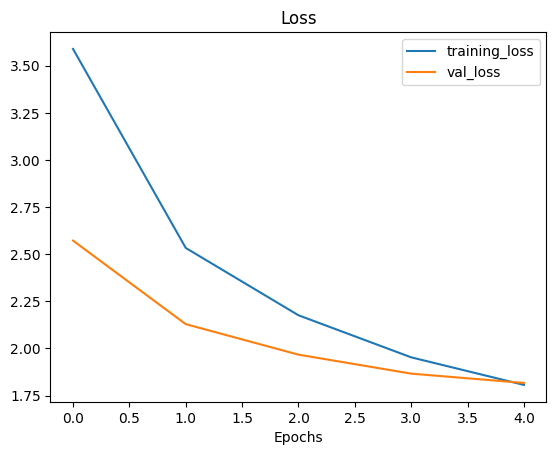

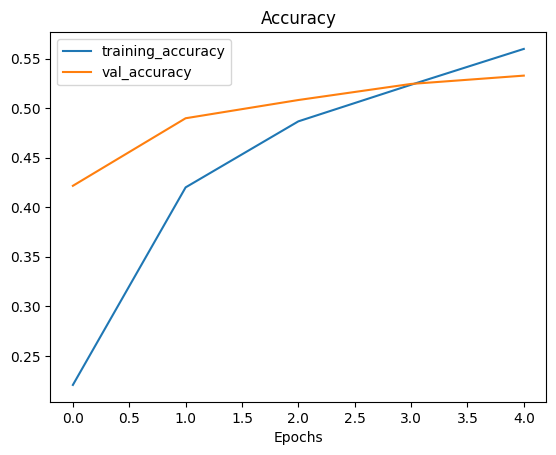

In [21]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [26]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [27]:
# Recompile the model with lower learning rate
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])


In [28]:
# Check what layers in our model are trainable
for layer in base_model.layers :
  print(layer.name , layer.trainable)

input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [31]:
# Fine-tune for more 5 epochs
fine_tune_epochs = 10 # model has already done 5 epochs

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data_all_10_percent,
                                                     validation_steps = int(0.15*len(test_data_all_10_percent)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 54s 180ms/step - accuracy: 0.5524 - loss: 0.1694 - val_accuracy: 0.4131 - val_loss: 0.0395
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - accuracy: 0.5611 - loss: 0.0394 - val_accuracy: 0.4899 - val_loss: 0.0365
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 165ms/step - accuracy: 0.5874 - loss: 0.0330 - val_accuracy: 0.5564 - val_loss: 0.0315
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 166ms/step - accuracy: 0.6024 - loss: 0.0304 - val_accuracy: 0.5609 - val_loss: 0.0320
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 167ms/step - accuracy: 0.6287 - loss: 0.0286 - val_accuracy: 0.6147 - val_loss: 0.0282
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - accuracy: 0.6250 - loss: 0.0277 - val_accuracy: 0.5943 - val_loss: 0.0277


In [32]:
# Evaluate fine-tuned modle on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data_all_10_percent)
results_all_classes_10_percent_fine_tune

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.5365 - loss: 0.0314


[0.030104028061032295, 0.5565544366836548]

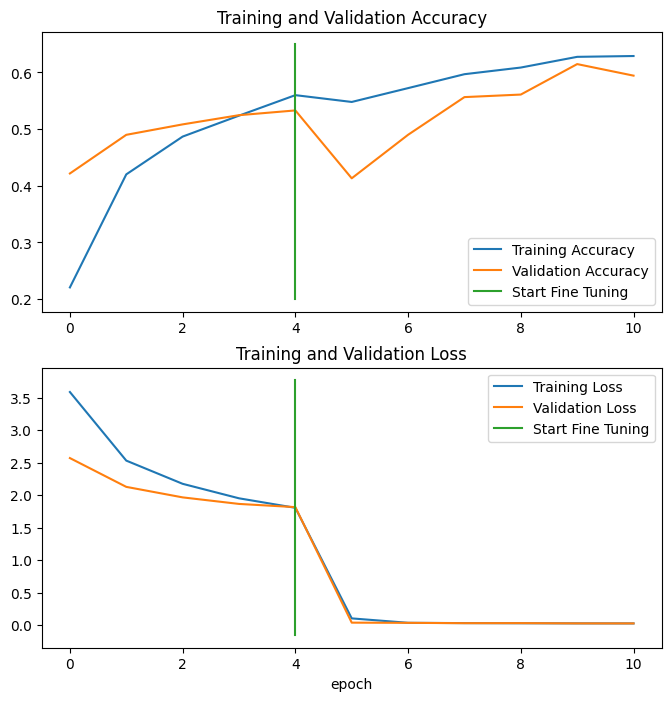

In [33]:
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Saving the model

In [40]:
# Save model to the drive so it can be used later
# model.save('101_food_casses_10_percent_saved_big_dog_model.h5')

## Evaluating the performance

In [39]:
# import tensorflow as tf

# # Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
# saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
# unzip_data(saved_model_path)

# # Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# # There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# # model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
# model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

In [41]:
# Make predictions with model =
pred_probs = model.predict(test_data_all_10_percent, verbose = 1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 70ms/step


In [42]:
# How many predictions are there
len(pred_probs)

25250

In [43]:
# Checking the number of predictions
pred_probs.shape

(25250, 101)

In [44]:
# How do they look
pred_probs[:10]

array([[1.1298778e-01, 9.8457402e-03, 1.5670951e-01, ..., 5.8503920e-04,
        1.5590530e-02, 2.7625715e-02],
       [8.7301451e-01, 3.1380853e-06, 2.3223397e-03, ..., 3.8239369e-03,
        1.6046965e-06, 1.0312726e-05],
       [1.0198757e-01, 6.9841389e-03, 6.0781767e-03, ..., 2.5535263e-03,
        8.7613135e-04, 3.6939329e-03],
       ...,
       [2.3369296e-01, 6.6046377e-05, 3.7089300e-03, ..., 6.3293755e-02,
        1.0764622e-03, 9.5480657e-04],
       [1.0795214e-01, 2.9562847e-03, 6.9342650e-02, ..., 1.3230044e-03,
        7.4112759e-04, 9.0371381e-04],
       [4.3455842e-01, 4.7075366e-05, 2.5346915e-03, ..., 8.7958146e-03,
        6.8667505e-05, 9.1752526e-04]], dtype=float32)

In [47]:
# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis =1)

# How do they look ?
pred_classes[:10]

array([ 2,  0,  7, 38,  8, 78, 29, 46,  9,  0])

## Unbatching the Data

In [49]:
y_labels = []

for images, labels in test_data_all_10_percent.unbatch() :
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Evaluating our model predictions

In [51]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.5565544554455446

In [53]:
from helper_functions import make_confusion_matrix

In [57]:
# Get the class names
class_names = test_data_all_10_percent.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [58]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100,100),
                      text_size = 20,
                      norm = False,
                      savefig = True)

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.32      0.14      0.20       250
           1       0.34      0.76      0.47       250
           2       0.58      0.55      0.57       250
           3       0.69      0.49      0.57       250
           4       0.42      0.48      0.45       250
           5       0.34      0.33      0.34       250
           6       0.72      0.72      0.72       250
           7       0.74      0.73      0.73       250
           8       0.26      0.40      0.31       250
           9       0.32      0.70      0.44       250
          10       0.39      0.44      0.41       250
          11       0.78      0.47      0.59       250
          12       0.69      0.56      0.62       250
          13       0.47      0.48      0.47       250
          14       0.47      0.52      0.50       250
          15       0.38      0.23      0.28       250
          16       0.58      0.46      0.52       250
          17       0.36    

In [62]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict = True)
classification_report_dict

{'0': {'precision': 0.32142857142857145,
  'recall': 0.144,
  'f1-score': 0.19889502762430938,
  'support': 250.0},
 '1': {'precision': 0.3350970017636684,
  'recall': 0.76,
  'f1-score': 0.46511627906976744,
  'support': 250.0},
 '2': {'precision': 0.5822784810126582,
  'recall': 0.552,
  'f1-score': 0.5667351129363449,
  'support': 250.0},
 '3': {'precision': 0.6892655367231638,
  'recall': 0.488,
  'f1-score': 0.5714285714285714,
  'support': 250.0},
 '4': {'precision': 0.41580756013745707,
  'recall': 0.484,
  'f1-score': 0.44731977818853974,
  'support': 250.0},
 '5': {'precision': 0.33877551020408164,
  'recall': 0.332,
  'f1-score': 0.33535353535353535,
  'support': 250.0},
 '6': {'precision': 0.724,
  'recall': 0.724,
  'f1-score': 0.724,
  'support': 250.0},
 '7': {'precision': 0.7398373983739838,
  'recall': 0.728,
  'f1-score': 0.7338709677419355,
  'support': 250.0},
 '8': {'precision': 0.2584856396866841,
  'recall': 0.396,
  'f1-score': 0.3127962085308057,
  'support': 25

In [66]:
# lets narrow it down
class_f1_scores = {}
# Loop through classificationi report items
for k, v in classification_report_dict.items():
  if k == 'accuracy' :
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.19889502762430938,
 'baby_back_ribs': 0.46511627906976744,
 'baklava': 0.5667351129363449,
 'beef_carpaccio': 0.5714285714285714,
 'beef_tartare': 0.44731977818853974,
 'beet_salad': 0.33535353535353535,
 'beignets': 0.724,
 'bibimbap': 0.7338709677419355,
 'bread_pudding': 0.3127962085308057,
 'breakfast_burrito': 0.4435994930291508,
 'bruschetta': 0.41263940520446096,
 'caesar_salad': 0.5870646766169154,
 'cannoli': 0.6164079822616408,
 'caprese_salad': 0.47410358565737054,
 'carrot_cake': 0.4952741020793951,
 'ceviche': 0.28428927680798005,
 'cheese_plate': 0.5155555555555555,
 'cheesecake': 0.397887323943662,
 'chicken_curry': 0.4145785876993166,
 'chicken_quesadilla': 0.5727482678983834,
 'chicken_wings': 0.6690647482014388,
 'chocolate_cake': 0.455,
 'chocolate_mousse': 0.31877729257641924,
 'churros': 0.7103594080338267,
 'clam_chowder': 0.7065868263473054,
 'club_sandwich': 0.6451612903225806,
 'crab_cakes': 0.36401673640167365,
 'creme_brulee': 0.70919324577861

In [69]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({'class_name':list(class_f1_scores.keys()),
                         'f1-score':list(class_f1_scores.values())}).sort_values('f1-score',ascending = False)
f1_scores.head()

,class_name,f1-score
33,edamame,0.941860
63,macarons,0.831111
86,sashimi,0.797794
45,frozen_yogurt,0.796429
69,oysters,0.793037


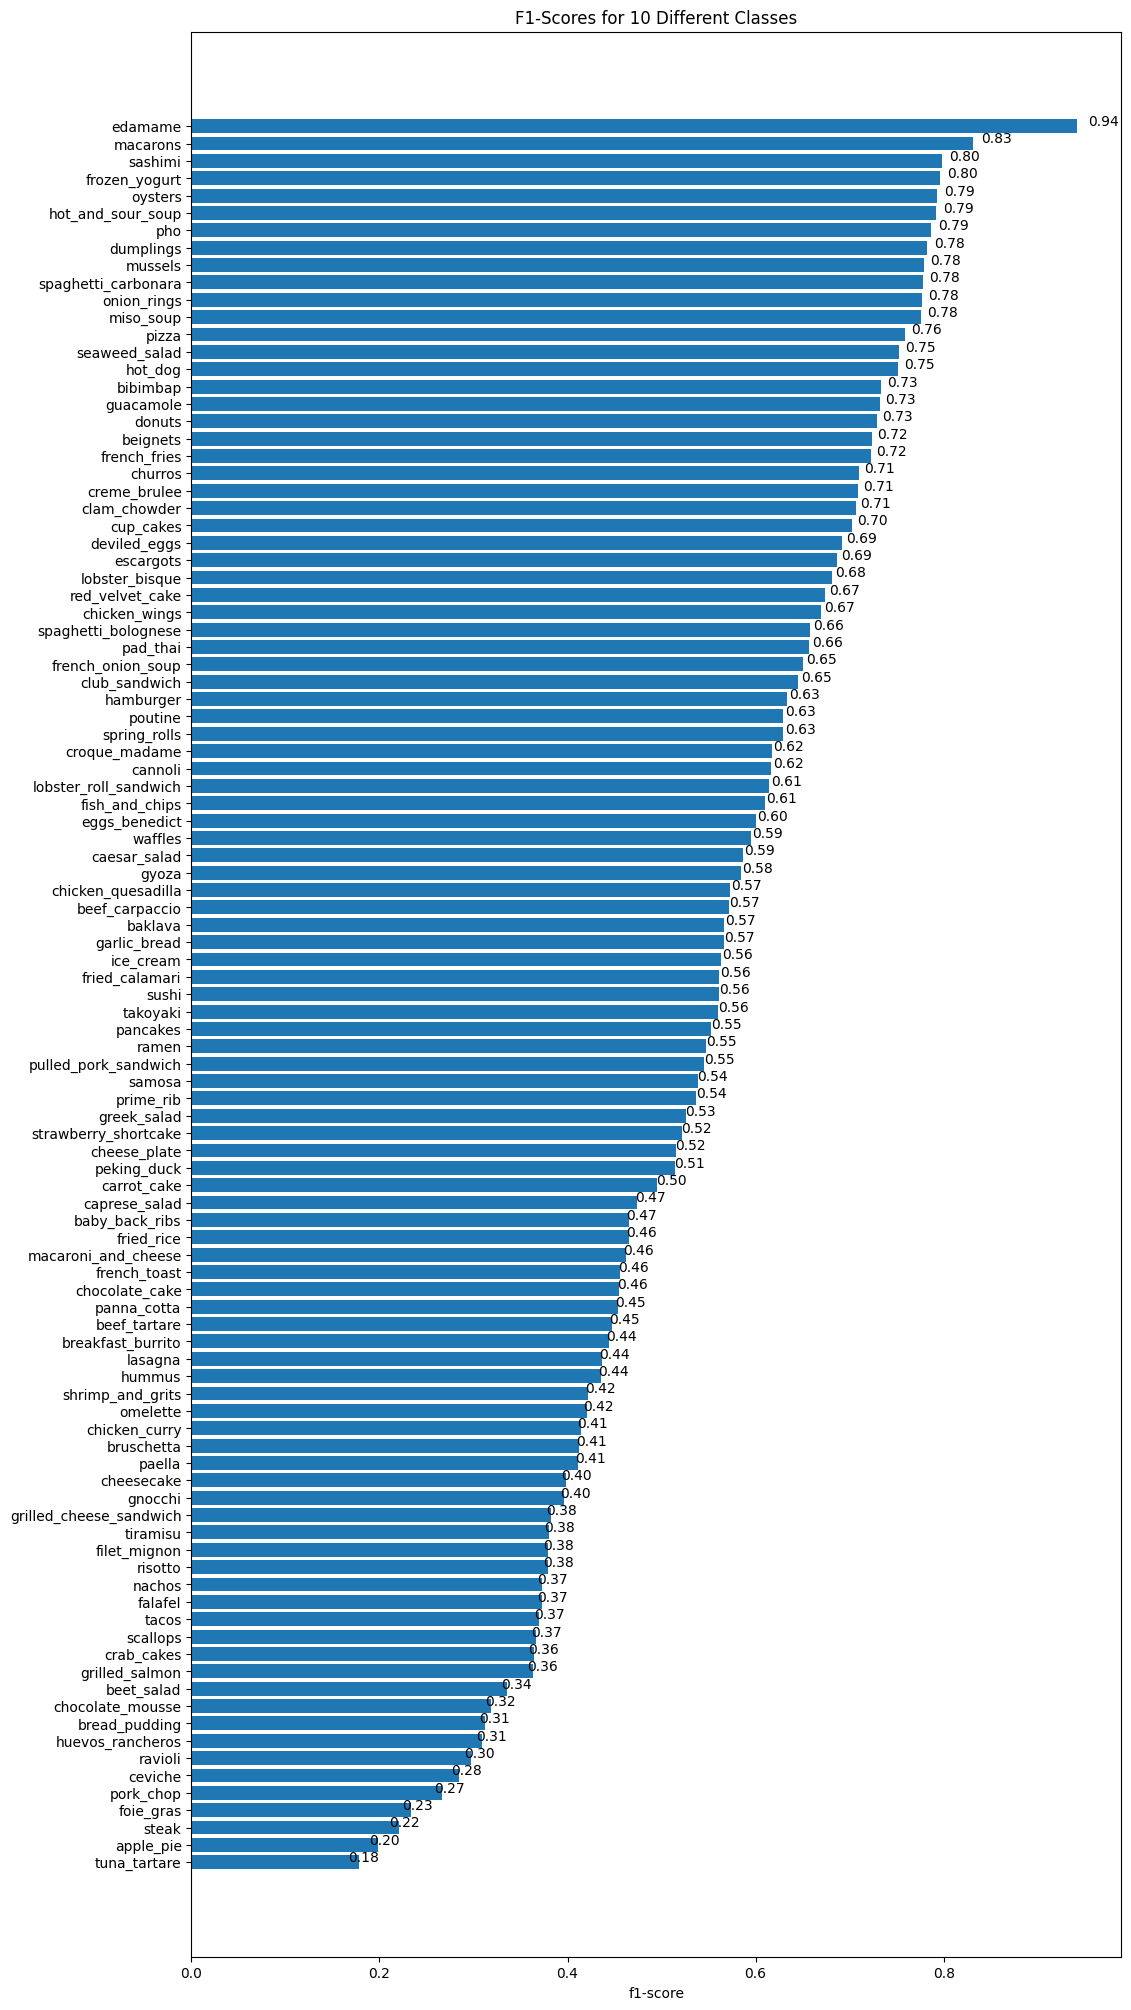

In [70]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [71]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


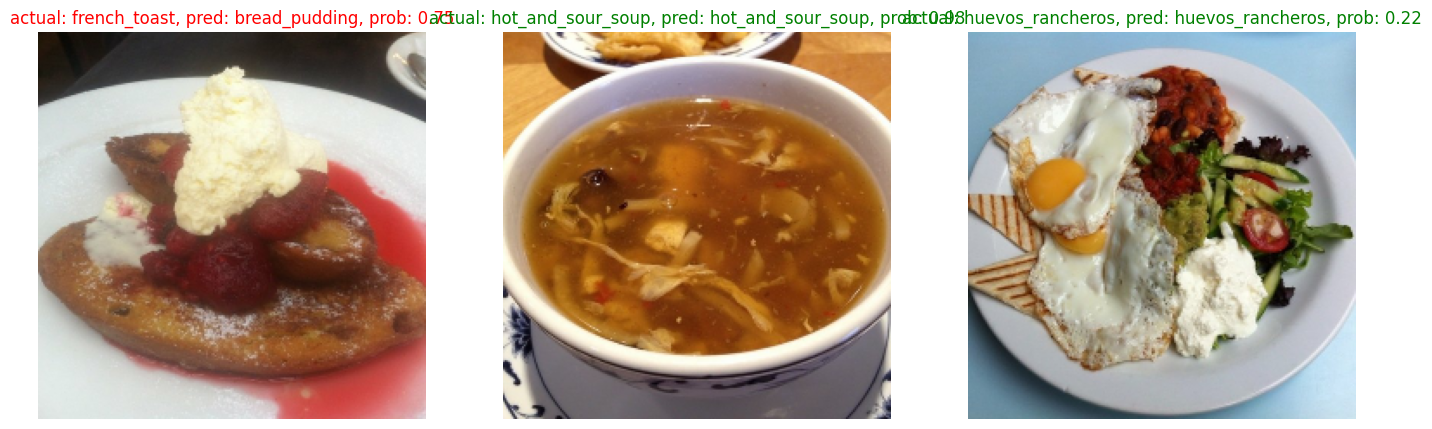

In [80]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);